### **Imports**

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

#from tensorflow.keras.applications.imagenet_utils import preprocess_input
#from keras.applications.vgg16 import preprocess_input, decode_prediction
from tensorflow.keras.regularizers import *
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
'''
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)
'''
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)



### **Mount & set directory**


In [0]:
home_dir = '..\\'
baum_dir = home_dir + 'BAUM\\'

data = pd.read_csv(baum_dir + 'training_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})
data_valid = pd.read_csv(baum_dir + 'validation_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})

data = shuffle(data)
data_valid = shuffle(data_valid)
'''
print("Original data", len(data),  len(data_valid))
def sampling_k_elements(group, k=4000):
    if len(group) < k:
        return group
    return group.sample(k)

def sampling_k_elements_valid(group, k=1000):
    if len(group) < k:
        return group
    return group.sample(k)

data = data.groupby('code').apply(sampling_k_elements).reset_index(drop=True)
data_valid = data_valid.groupby('code').apply(sampling_k_elements_valid).reset_index(drop=True)
print("Less data", len(data),  len(data_valid))

data = shuffle(data)
data_valid = shuffle(data_valid)
#ax3 = data['code'].plot.hist(bins=12)
'''

'\nprint("Original data", len(data),  len(data_valid))\ndef sampling_k_elements(group, k=4000):\n    if len(group) < k:\n        return group\n    return group.sample(k)\n\ndef sampling_k_elements_valid(group, k=1000):\n    if len(group) < k:\n        return group\n    return group.sample(k)\n\ndata = data.groupby(\'code\').apply(sampling_k_elements).reset_index(drop=True)\ndata_valid = data_valid.groupby(\'code\').apply(sampling_k_elements_valid).reset_index(drop=True)\nprint("Less data", len(data),  len(data_valid))\n\ndata = shuffle(data)\ndata_valid = shuffle(data_valid)\n#ax3 = data[\'code\'].plot.hist(bins=12)\n'

In [0]:
data.head()

,flow,spatial,emotion,code
1835,imgs_flow\s002\S002_018\794.png,imgs_spatial\s002\S002_018\794.png,Happiness,4
36432,imgs_flow\s022\S022_048\061.png,imgs_spatial\s022\S022_048\061.png,Sadness,5
4788,imgs_flow\s003\S003_015\070.png,imgs_spatial\s003\S003_015\070.png,Happiness,4
7315,imgs_flow\s003\S003_041\307.png,imgs_spatial\s003\S003_041\307.png,Happiness,4
8615,imgs_flow\s004\S004_026\609.png,imgs_spatial\s004\S004_026\609.png,Sadness,5


### **Data Analysis and Visualization**

Unique classes are:  ['4', '5', '6', '2', '1', '3']
..\BAUM\imgs_spatial\s008\S008_030\032.png
..\BAUM\imgs_spatial\s002\S002_018\657.png
..\BAUM\imgs_spatial\s019\S019_055\024.png
..\BAUM\imgs_spatial\s008\S008_032\125.png
..\BAUM\imgs_spatial\s016\S016_012\028.png
..\BAUM\imgs_spatial\s023\S023_037\041.png
..\BAUM\imgs_spatial\s004\S004_046\031.png
..\BAUM\imgs_spatial\s004\S004_028\358.png
..\BAUM\imgs_spatial\s015\S015_019\004.png
..\BAUM\imgs_spatial\s008\S008_050\215.png


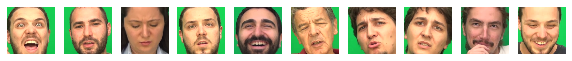

['Anger', 'Happiness', 'Anger', 'Sadness', 'Happiness', 'Sadness', 'Disgust', 'Sadness', 'Happiness', 'Happiness']


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
data_unique = data['code'].unique().tolist()
print("Unique classes are: ",data_unique)

images = []
images_flow = []
emotions = []
codes = []
i = 0
while i < 10:
  
  sample = data.sample()
  spatial = sample['spatial'] 
  emotion = sample['emotion'] 
  code = sample['code']

  spatial = spatial.values[0]
  emotion = emotion.values[0]
  code = code.values[0]

  img_path = baum_dir + spatial
  print (img_path)
  if (os.path.isfile(img_path)):
    images.append(mpimg.imread(img_path))
    emotions.append(emotion)
    codes.append(code)
    i+=1

plt.figure(figsize=(10,15))
columns = 10

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()
print(emotions)

### **Image generators**

In [0]:
train_df, valid_df = data , data_valid

batch_size_ = 256

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_spatial = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_spatial = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

train_generator_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_flow = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

def combine_generator(gen1, gen2):
    while True:    
        X1i = gen1.next()
        X2i = gen2.next()
        frame = X1i[0][0]
        #cv2.imwrite( str(X1i[1][0]) +".png",frame )
        #cv2.imwrite("f.png", X2i[0][0])
        yield [X1i[0], X2i[0]], X1i[1]  #X1i[1] is the label


train_generator = combine_generator(train_generator_spatial, train_generator_flow)
validation_generator = combine_generator(validation_generator_spatial, validation_generator_flow)

validation_generator_spatial_2 = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

print ("generators initiaized")


Found 47169 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
Found 47169 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
generators initiaized


### **Model & setting**

In [0]:
def create_model():
    input_spatial = Input(shape=(48,48,3))
    x = layers.Conv2D(128, (5, 5), activation='relu')(input_spatial)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    Out_spatial = layers.GlobalAveragePooling2D()(x)
    #x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    #Out_spatial = layers.Flatten()(x)

    input_flow = Input(shape=(48,48,3))
    x = layers.Conv2D(128, (5, 5), activation='relu')(input_flow)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    Out_flow = layers.GlobalAveragePooling2D()(x)
    #x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    #Out_flow = layers.Flatten()(x)
    
    merged = Add()([Out_spatial, Out_flow])
    #merged = sum([Out_spatial, Out_flow])

    x = layers.Dense(1024, activation='relu')(merged)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.05))(x)
    x = layers.Dropout(0.1)(x)

    Out = layers.Dense(6, activation='softmax')(x)

    model = models.Model(inputs=[input_spatial, input_flow], outputs=[Out])
    return model


model = create_model()
print (model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 44, 44, 128)  9728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 44, 44, 128)  9728        input_2[0][0]                    
_____________

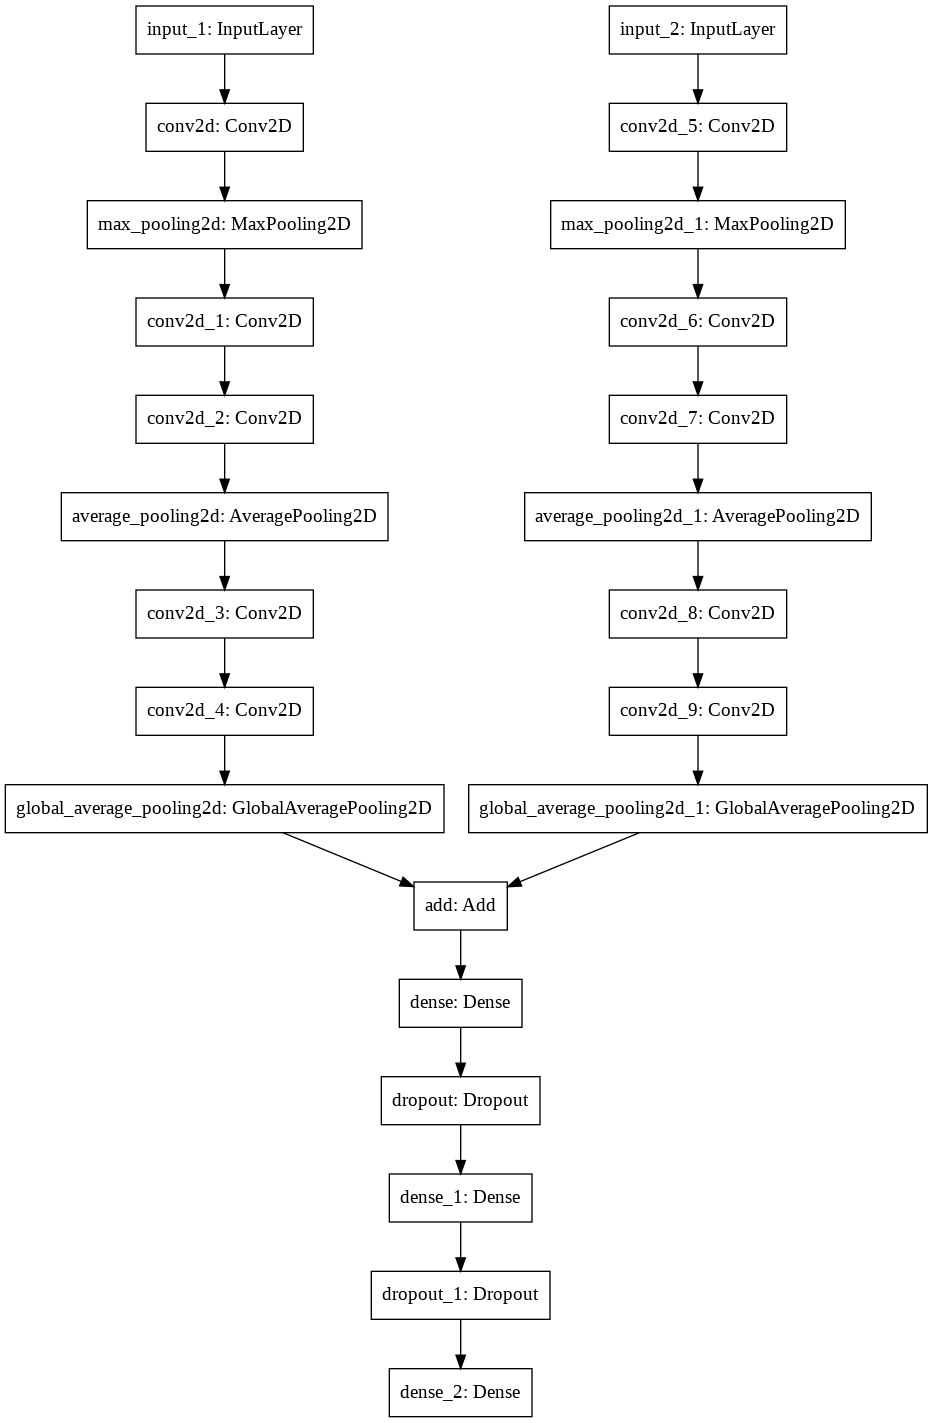

In [0]:
# Plot Model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### **Train**

In [0]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.00001, rho=0.9),
              metrics=['acc'])

In [0]:
# Auto-save model weights with best val_acc
modelPath  = baum_dir + 'models\\addGAP.h5'
checkpoint = ModelCheckpoint(modelPath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

# Train The Model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=int(len(train_df) / batch_size_),
        epochs=50,
        #workers=8,
        #use_multiprocessing=True,
        validation_data=validation_generator,
        validation_steps=int(len(valid_df) / batch_size_),
        callbacks = callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
 29/184 [===>..........................] - ETA: 2:54 - loss: 47.6280 - acc: 0.0853
Epoch 00001: val_acc improved from -inf to 0.08526, saving model to ..\BAUM\models\addGAP.h5
184/184 [==============================] - 294s 2s/step - loss: 50.0569 - acc: 0.3420 - val_loss: 47.6280 - val_acc: 0.0853
Epoch 2/50
 29/184 [===>..........................] - ETA: 2:51 - loss: 42.9886 - acc: 0.0853
Epoch 00002: val_acc did not improve from 0.08526
184/184 [==============================] - 281s 2s/step - loss: 45.1929 - acc: 0.3534 - val_loss: 42.9886 - val_acc: 0.0853
Epoch 3/50
 29/184 [===>..........................] - ETA: 2:53 - loss: 38.6816 - acc: 0.0853
Epoch 00003: val_acc did not improve from 0.08526
184/184 [==============================] - 271s 1s/step - loss: 40.7088 - acc: 0.3550 - val_loss: 38.6816 - val_acc: 0.0853
Epoch 4/50
 29/184 [===>..........................] - ETA: 2:50 - loss: 34.67

 29/184 [===>..........................] - ETA: 2:24 - loss: 2.7627 - acc: 0.5397
Epoch 00022: val_acc did not improve from 0.56296
184/184 [==============================] - 233s 1s/step - loss: 2.9014 - acc: 0.4863 - val_loss: 2.7627 - val_acc: 0.5397
Epoch 23/50
 28/184 [===>..........................] - ETA: 2:31 - loss: 2.4263 - acc: 0.5614
Epoch 00023: val_acc did not improve from 0.56296
184/184 [==============================] - 235s 1s/step - loss: 2.5450 - acc: 0.4856 - val_loss: 2.4270 - val_acc: 0.5616
Epoch 24/50
 29/184 [===>..........................] - ETA: 2:36 - loss: 2.2247 - acc: 0.5185
Epoch 00024: val_acc did not improve from 0.56296
184/184 [==============================] - 256s 1s/step - loss: 2.2650 - acc: 0.4885 - val_loss: 2.2247 - val_acc: 0.5185
Epoch 25/50
 29/184 [===>..........................] - ETA: 2:24 - loss: 2.0074 - acc: 0.5575
Epoch 00025: val_acc did not improve from 0.56296
184/184 [==============================] - 234s 1s/step - loss: 2.0477

Epoch 45/50
 29/184 [===>..........................] - ETA: 2:36 - loss: 1.4211 - acc: 0.5692
Epoch 00045: val_acc did not improve from 0.57247
184/184 [==============================] - 253s 1s/step - loss: 1.3034 - acc: 0.5477 - val_loss: 1.4211 - val_acc: 0.5692
Epoch 46/50
 29/184 [===>..........................] - ETA: 2:20 - loss: 1.5951 - acc: 0.4386
Epoch 00046: val_acc did not improve from 0.57247
184/184 [==============================] - 225s 1s/step - loss: 1.2955 - acc: 0.5492 - val_loss: 1.5951 - val_acc: 0.4386
Epoch 47/50
 29/184 [===>..........................] - ETA: 2:31 - loss: 1.4535 - acc: 0.5521
Epoch 00047: val_acc did not improve from 0.57247
184/184 [==============================] - 250s 1s/step - loss: 1.2858 - acc: 0.5533 - val_loss: 1.4535 - val_acc: 0.5521
Epoch 48/50
 29/184 [===>..........................] - ETA: 2:21 - loss: 1.6364 - acc: 0.4076
Epoch 00048: val_acc did not improve from 0.57247
184/184 [==============================] - 223s 1s/step - 

### **End**

In [0]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


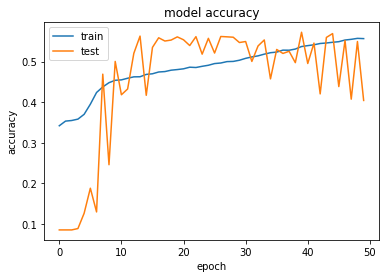

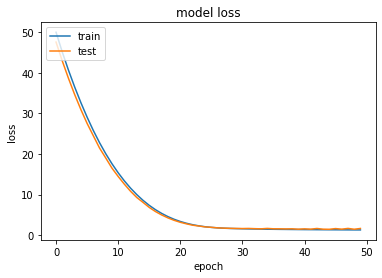

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model_path  = baum_dir + 'models\\addGAP.h5'

# load and evaluate a saved model
model = load_model(model_path)


P = model.predict_generator(generator=validation_generator,
                                   max_queue_size =5,
                                   verbose=1,
                                   steps=len(valid_df)//batch_size_)


Instructions for updating:
Please use Model.predict, which supports generators.
29/29 [==============================] - 19s 658ms/step


7258 7258


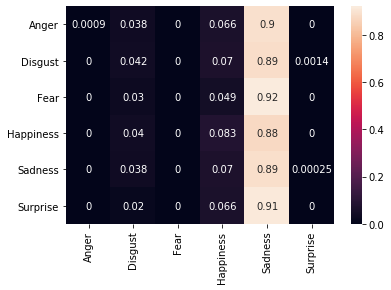

In [0]:
y_predict = np.argmax(P, axis=1)

y_true = validation_generator_spatial_2.classes[:len(y_predict)]

print(len(y_predict), len(y_true))
cm = confusion_matrix(y_true, y_predict)

lables = ['Anger' , 'Disgust' , 'Fear' , 'Happiness', 'Sadness', 'Surprise']
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, xticklabels=lables, yticklabels=lables)

In [0]:
calssifiers =['haarcascade_frontalface_default.xml',
              'haarcascade_frontalface_alt2.xml',
              'haarcascade_frontalcatface_extended.xml',
              'haarcascade_frontalcatface.xml',
              'haarcascade_frontalface_alt_tree.xml',
              'haarcascade_frontalface_alt.xml']

def detectFace(img):
    for classifier in calssifiers:
        face_cascade = cv2.CascadeClassifier(home_dir +'face_detectors/' + classifier)
        faces = face_cascade.detectMultiScale(img, 1.3, 1)
        if (len(faces) > 0):
            return faces
    faces = []
    return faces

In [0]:
import cv2
import numpy as np
from glob import glob
import pandas as pd
from random import randint
from random import seed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython import display
import os

#seed(2)
temp_image = np.array([])
none_image = None

videos = glob(baum_dir+'BAUM1s_MP4 - All\\*\\*.mp4')
emotions = ['Anger', 'Sadness', 'Surprise', 'Disgust', 'Fear', 'Happiness']

data_labels_xl =  pd.read_excel(baum_dir + "Annotations_BAUM1s.xlsx")
data_labels = np.array(data_labels_xl)

#print (vid)
# Assert Video Code
val = randint(0, len(videos)-1)
#print (len(videos))
vid = videos[val]
vidName = vid.split('\\')[-1].split('.')[0]
vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])

while vidCode not in ([1, 10, 11, 6, 7, 8]):
  val = randint(0, len(videos))
  vid = videos[val]
  vidName = vid.split('\\')[-1].split('.')[0]
  #print (vidName)
  try:
    vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
    vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])
  except:
    print ("Video Emotion Not Found")
print ('Video Name: {} Label: {}'.format(vidName, vidLabel))

video_output = baum_dir +'output.mp4'
cap = cv2.VideoCapture(vid)
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_gray = cv2.resize(old_gray, (100,100))

clip = VideoFileClip(vid)

count_frames = 0
calcOpticalFlow = -1
def process_image_challenge(frame):
  global calcOpticalFlow, old_gray, count_frames
  count_frames += 1
  #if isinstance(frame, type(temp_image)) and not isinstance(frame, type(none_image)) :
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = detectFace(frame_gray)
  if len(faces) == 0:
      calcOpticalFlow = 0
      print("Old frame due to no faces")
      return frame #return original frame of video

  (x,y,w,h)  = faces[0]
  frame_gray = frame_gray[y:y+h, x:x+w]
  roi_color = frame[y:y+h, x:x+w]

  if(frame_gray.shape[0] < 90 or roi_color.shape[0] < 90 ):
      print("Old frame due to small size")
      calcOpticalFlow = 0
      return frame #return original frame of video

  frame_gray = cv2.resize(frame_gray, (100,100))
  roi_color = cv2.resize(roi_color, (100,100))

  calcOpticalFlow += 1
  hsv = np.zeros_like(roi_color)
  hsv[...,1] = 255

  if (calcOpticalFlow > 1 ):
    flow = cv2.calcOpticalFlowFarneback(old_gray,frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)            
    mag, ang   = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    flowImg = cv2.resize(rgb, (48,48))
    flowImg = flowImg/255.0
    flowImg = flowImg.reshape(-1, 48,48,3)
    roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
    spatialImg = cv2.resize(roi_color, (48,48))
    spatialImg = spatialImg/255.0
    spatialImg = spatialImg.reshape(-1, 48,48,3)
    
    out = model.predict([spatialImg, flowImg])
    org = (50, 50)   
    # fontScale 
    fontScale = 1 
    font = cv2.FONT_HERSHEY_SIMPLEX      
    # Blue color in BGR 
    color = (255, 0, 0)   
    # Line thickness of 2 px 
    thickness = 2    
    # Using cv2.putText() method 
    txt = 'Ground Truth: {}, Out: {}'.format(vidLabel, emotions[np.argmax(out[0])])
    #print ('True: {}, Out: {}, Prob.: {}'.format(vidLabel, emotions[np.argmax(out[0])], out[0]))
    frame = cv2.putText(frame, txt, org, font,  
                      fontScale, color, thickness, cv2.LINE_AA) 
 
  old_gray = frame_gray.copy()
  return frame

challenge_clip = clip.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(video_output, audio=False)
print(count_frames , frameCount)
print("The random index is ", val)


Video Name: S016_004 Label: Happiness


t:   0%|                                                                                                                                                        | 0/92 [00:00<?, ?it/s, now=None]

Moviepy - Building video ..\BAUM\output.mp4.
Moviepy - Writing video ..\BAUM\output.mp4



t:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 57/92 [00:02<00:01, 21.99it/s, now=None]

Old frame due to small size


Moviepy - Done !
Moviepy - video ready ..\BAUM\output.mp4
Wall time: 4.57 s
93 91
The random index is  513


In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_output,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)